# Visualizações e Análise Exploratória

Este notebook gera visualizações dos dados e resultados do modelo.


In [1]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (15, 6)

# Configurações
POSTGRES_HOST = 'postgres'
POSTGRES_USER = 'postgres'
POSTGRES_PASSWORD = 'postgres'
POSTGRES_DB = 'inmet_db'

engine = create_engine(f'postgresql://{POSTGRES_USER}:{POSTGRES_PASSWORD}@{POSTGRES_HOST}:5432/{POSTGRES_DB}')


In [2]:
# Carrega dados tratados
df = pd.read_sql("SELECT * FROM dados_tratados ORDER BY datetime", engine)
df['datetime'] = pd.to_datetime(df['datetime'])
print(f"Total de registros: {len(df)}")


Total de registros: 7161


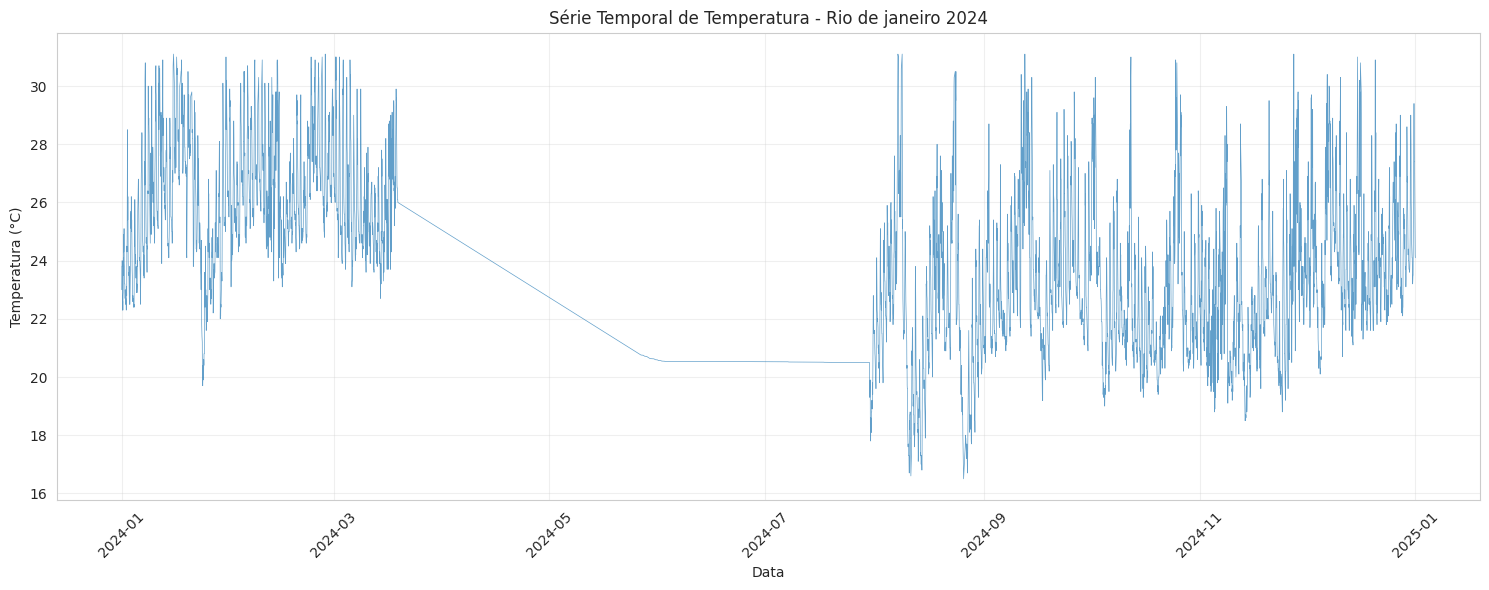

In [3]:
# Série temporal de temperatura
plt.figure(figsize=(15, 6))
plt.plot(df['datetime'], df['temperatura'], linewidth=0.5, alpha=0.7)
plt.xlabel('Data')
plt.ylabel('Temperatura (°C)')
plt.title('Série Temporal de Temperatura - Rio de janeiro 2024')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('/home/jovyan/work/serie_temporal_temperatura.png', dpi=300, bbox_inches='tight')
plt.show()


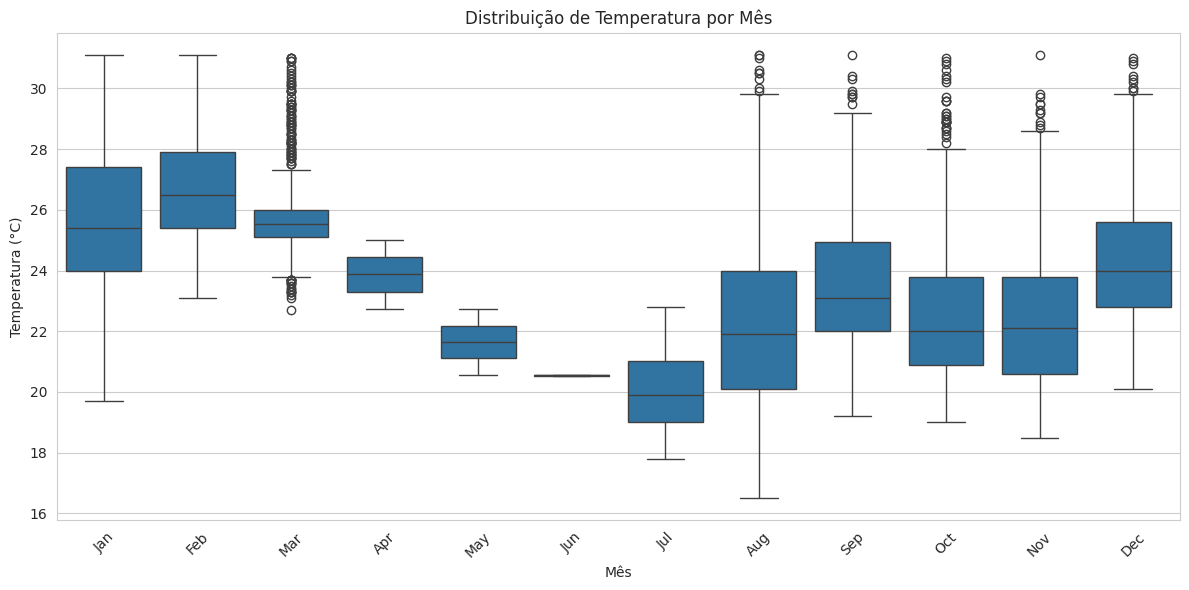

In [4]:
# Boxplot de temperatura por mês
df['mes_nome'] = df['datetime'].dt.strftime('%b')
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='mes_nome', y='temperatura', order=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                                                           'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.xlabel('Mês')
plt.ylabel('Temperatura (°C)')
plt.title('Distribuição de Temperatura por Mês')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('/home/jovyan/work/temperatura_por_mes.png', dpi=300, bbox_inches='tight')
plt.show()


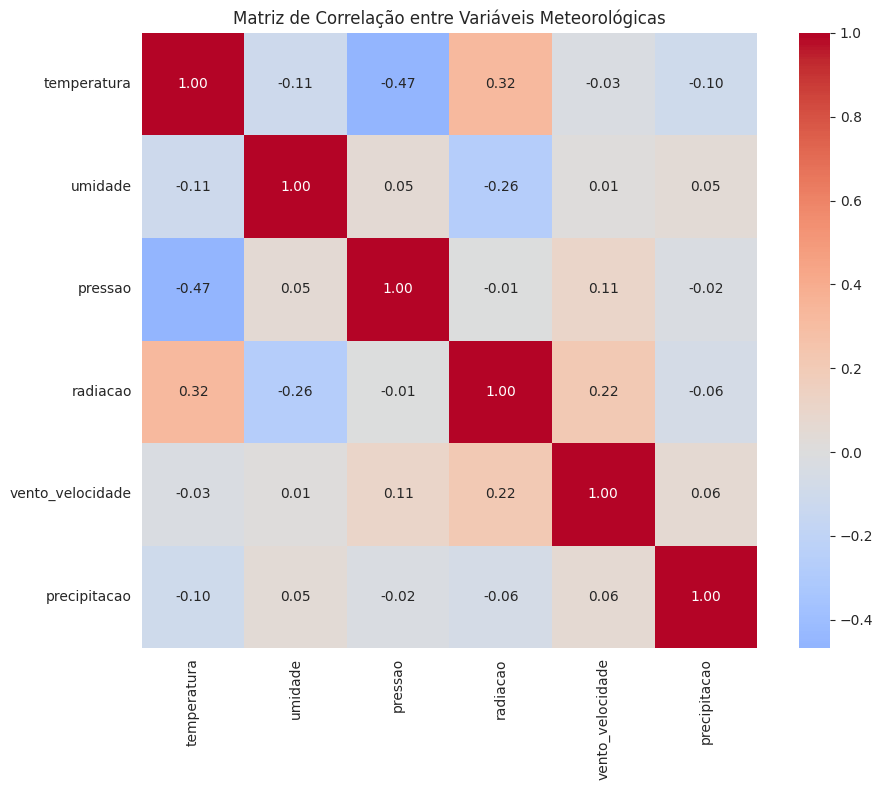

In [5]:
# Correlação entre variáveis
corr_cols = ['temperatura', 'umidade', 'pressao', 'radiacao', 'vento_velocidade', 'precipitacao']
corr_matrix = df[corr_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, square=True)
plt.title('Matriz de Correlação entre Variáveis Meteorológicas')
plt.tight_layout()
plt.savefig('/home/jovyan/work/matriz_correlacao.png', dpi=300, bbox_inches='tight')
plt.show()


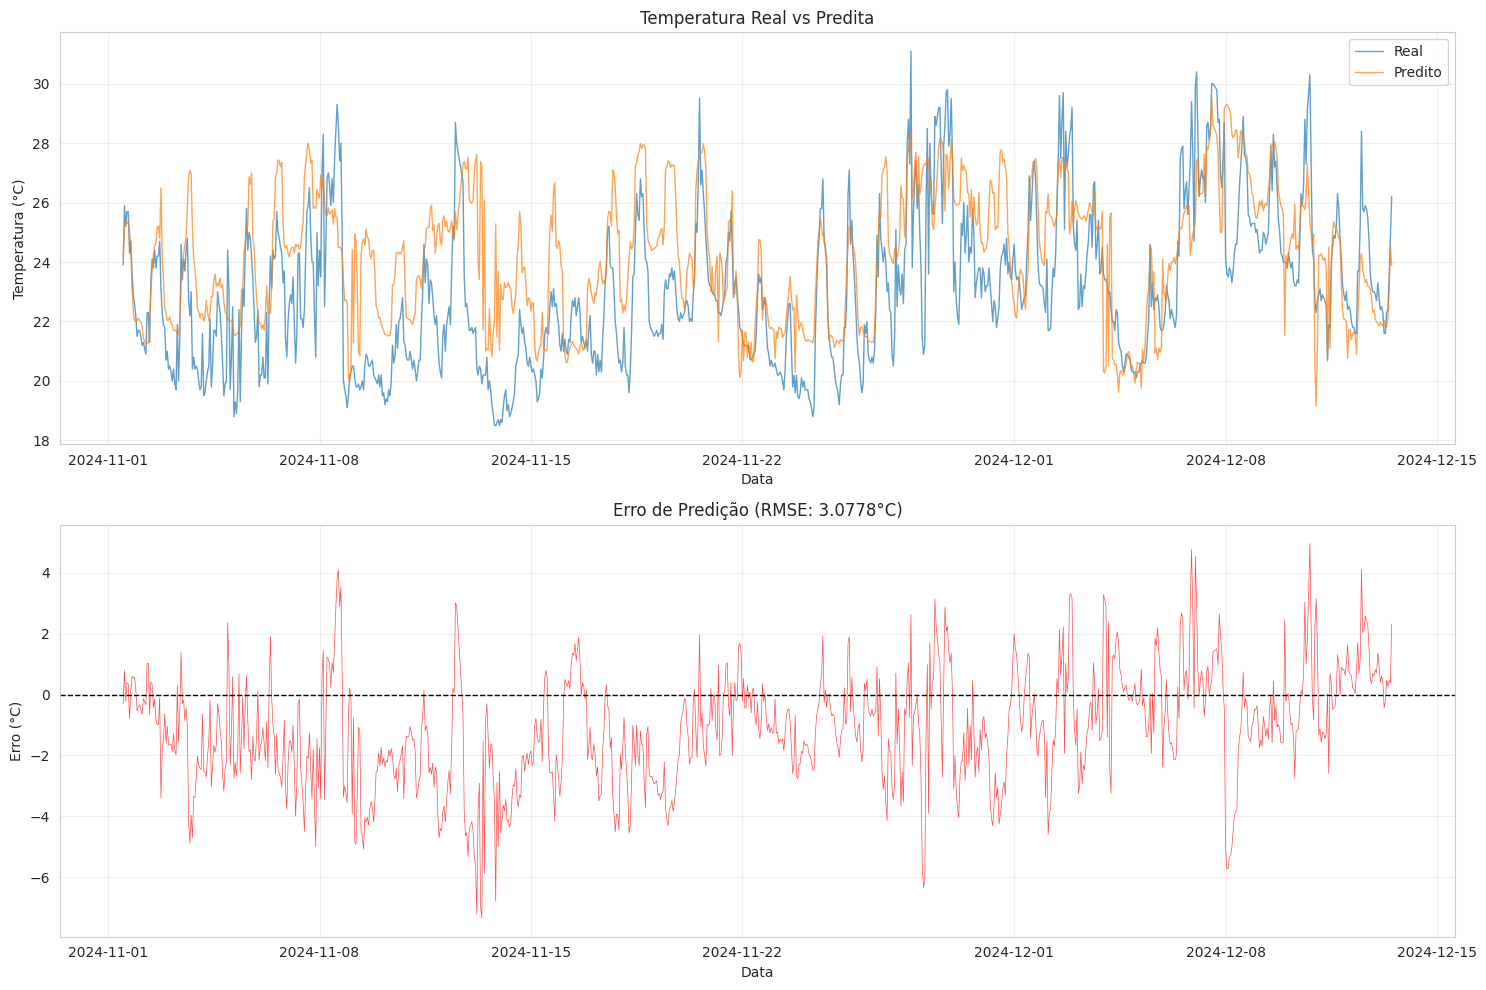

✅ RMSE: 3.0778°C
✅ MAE: 2.4163°C
✅ Total de predições: 1433


In [6]:
# Visualização de predições
try:
    pred_df = pd.read_sql("SELECT * FROM predicoes_temperatura ORDER BY datetime", engine)
    
    if pred_df.empty:
        print("⚠️ Tabela predicoes_temperatura está vazia. Execute primeiro o notebook 02_modelagem_temperatura.ipynb")
    else:
        pred_df['datetime'] = pd.to_datetime(pred_df['datetime'])
        
        # Erro de predição
        pred_df['erro'] = pred_df['temperatura_real'] - pred_df['temperatura_predita']
        pred_df['erro_abs'] = np.abs(pred_df['erro'])
        
        # Calcula RMSE se não existir na coluna
        if 'rmse' in pred_df.columns and not pred_df['rmse'].isna().all():
            rmse_value = pred_df['rmse'].iloc[0] if len(pred_df) > 0 else None
        else:
            # Calcula RMSE a partir dos dados
            rmse_value = np.sqrt(np.mean(pred_df['erro']**2))
            print(f"⚠️ RMSE calculado a partir dos dados: {rmse_value:.4f}°C")
        
        # Calcula MAE
        mae_value = pred_df['erro_abs'].mean()
        
        # Limita número de pontos para visualização (máximo 1000)
        n_points = min(1000, len(pred_df))
        
        fig, axes = plt.subplots(2, 1, figsize=(15, 10))
        
        # Série temporal com predições
        axes[0].plot(pred_df['datetime'][:n_points], pred_df['temperatura_real'][:n_points], 
                     label='Real', alpha=0.7, linewidth=1)
        axes[0].plot(pred_df['datetime'][:n_points], pred_df['temperatura_predita'][:n_points], 
                     label='Predito', alpha=0.7, linewidth=1)
        axes[0].set_xlabel('Data')
        axes[0].set_ylabel('Temperatura (°C)')
        axes[0].set_title('Temperatura Real vs Predita')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)
        
        # Erro ao longo do tempo
        axes[1].plot(pred_df['datetime'][:n_points], pred_df['erro'][:n_points], 
                     alpha=0.7, linewidth=0.5, color='red')
        axes[1].axhline(y=0, color='black', linestyle='--', linewidth=1)
        axes[1].set_xlabel('Data')
        axes[1].set_ylabel('Erro (°C)')
        
        # Título com RMSE (trata caso None)
        if rmse_value is not None:
            axes[1].set_title(f'Erro de Predição (RMSE: {rmse_value:.4f}°C)')
        else:
            axes[1].set_title('Erro de Predição')
        
        axes[1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig('/home/jovyan/work/visualizacao_predicoes.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        # Imprime métricas
        if rmse_value is not None:
            print(f"✅ RMSE: {rmse_value:.4f}°C")
        print(f"✅ MAE: {mae_value:.4f}°C")
        print(f"✅ Total de predições: {len(pred_df)}")
        
except Exception as e:
    print(f"❌ Erro ao carregar predições: {e}")
    print("Certifique-se de que executou o notebook 02_modelagem_temperatura.ipynb primeiro")
    import traceback
    traceback.print_exc()


In [7]:
# VERIFICAÇÃO: Ver quais dados temos no banco de dados
print("🔍 Verificando dados no banco de dados...")
df_check = pd.read_sql("SELECT datetime FROM dados_tratados ORDER BY datetime", engine)
df_check['datetime'] = pd.to_datetime(df_check['datetime'])

print(f"   Total de registros: {len(df_check)}")
print(f"   Período completo: {df_check['datetime'].min()} até {df_check['datetime'].max()}")
print(f"   Primeiro registro: {df_check.iloc[0]['datetime']}")
print(f"   Último registro: {df_check.iloc[-1]['datetime']}")
print(f"\n   📊 Distribuição por mês:")
distribuicao = df_check.groupby(df_check['datetime'].dt.to_period('M')).size()
print(distribuicao)
print(f"\n   ⚠️  Se só aparecer dezembro, os dados de janeiro-novembro não estão no banco!")


🔍 Verificando dados no banco de dados...
   Total de registros: 7161
   Período completo: 2024-01-01 00:00:00 até 2024-12-31 23:00:00
   Primeiro registro: 2024-01-01 00:00:00
   Último registro: 2024-12-31 23:00:00

   📊 Distribuição por mês:
datetime
2024-01    707
2024-02    665
2024-03    743
2024-04    720
2024-05    681
2024-06     12
2024-07     43
2024-08    707
2024-09    707
2024-10    731
2024-11    714
2024-12    731
Freq: M, dtype: int64

   ⚠️  Se só aparecer dezembro, os dados de janeiro-novembro não estão no banco!


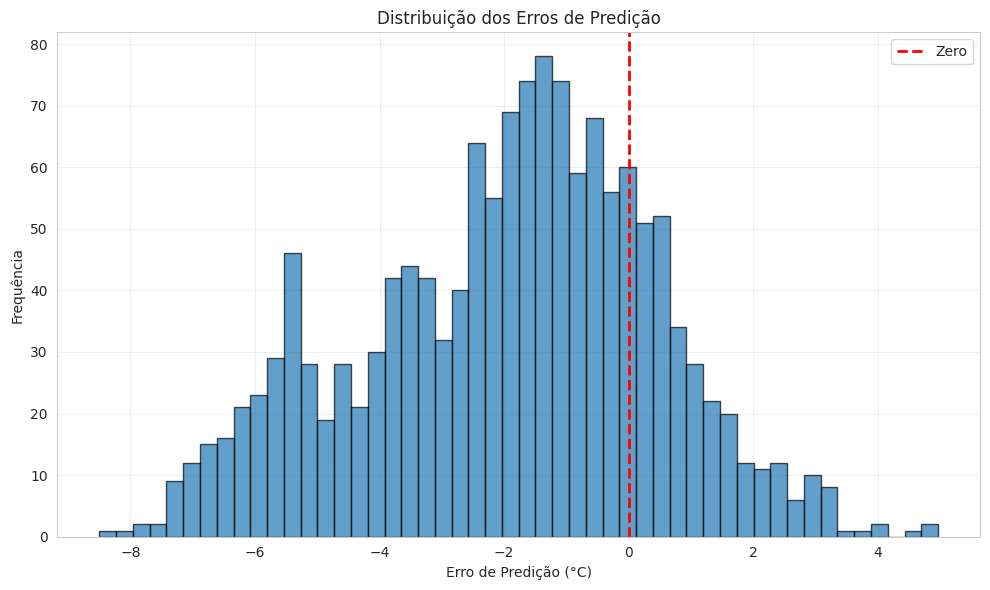

In [8]:
# Distribuição de erros
try:
    if 'pred_df' in locals() and not pred_df.empty and 'erro' in pred_df.columns:
        plt.figure(figsize=(10, 6))
        plt.hist(pred_df['erro'], bins=50, edgecolor='black', alpha=0.7)
        plt.xlabel('Erro de Predição (°C)')
        plt.ylabel('Frequência')
        plt.title('Distribuição dos Erros de Predição')
        plt.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig('/home/jovyan/work/distribuicao_erros.png', dpi=300, bbox_inches='tight')
        plt.show()
    else:
        print("⚠️ Não há dados de predições disponíveis para gerar o histograma")
except Exception as e:
    print(f"❌ Erro ao gerar histograma: {e}")


In [9]:
# Integração com ThingsBoard
import requests
import json
from datetime import datetime as dt
import time

# Configurações do ThingsBoard
THINGSBOARD_HOST_NAME = "thingsboard:9090"  # URL interna do container (sem http://)
THINGSBOARD_URL = f"http://{THINGSBOARD_HOST_NAME}"  # URL completa
THINGSBOARD_ACCESS_TOKEN = "Xb9g6fSLXaGmFs4fkD1W"  # Novo access token do dispositivo

def send_telemetry_to_thingsboard(data, access_token=THINGSBOARD_ACCESS_TOKEN, use_timestamp=True):
    """
    Envia dados de telemetria para o ThingsBoard via HTTP API
    Seguindo o formato oficial do ThingsBoard
    
    Args:
        data: Dicionário com os dados a serem enviados
        access_token: Token de acesso do ThingsBoard
        use_timestamp: Se True, usa formato com timestamp do cliente. Se False, usa formato simples.
    """
    # Endpoint oficial do ThingsBoard
    url = f"{THINGSBOARD_URL}/api/v1/{access_token}/telemetry"
    headers = {
        "Content-Type": "application/json"
    }
    
    try:
        response = requests.post(url, json=data, headers=headers, timeout=10)
        if response.status_code == 200:
            return True, "Dados enviados com sucesso"
        elif response.status_code == 401:
            return False, f"Erro 401 Unauthorized: Verifique o ACCESS_TOKEN"
        elif response.status_code == 400:
            return False, f"Erro 400 Bad Request: Verifique a sintaxe JSON. Resposta: {response.text}"
        else:
            return False, f"Erro HTTP {response.status_code}: {response.text}"
    except requests.exceptions.ConnectionError:
        return False, "Erro de conexão: ThingsBoard não está acessível. Verifique se o serviço está rodando."
    except Exception as e:
        return False, f"Erro ao enviar dados: {str(e)}"

# Envia dados meteorológicos para ThingsBoard
try:
    # Carrega dados tratados se ainda não estiverem carregados
    if 'df' not in locals() or df.empty:
        df = pd.read_sql("SELECT * FROM dados_tratados ORDER BY datetime", engine)
        df['datetime'] = pd.to_datetime(df['datetime'])
    
    print("📡 Enviando dados para ThingsBoard...")
    print(f"   Total de registros no banco: {len(df)}")
    
    # VERIFICAÇÃO: Mostra o período completo dos dados
    print(f"   📅 Período no banco: {df['datetime'].min()} até {df['datetime'].max()}")
    
    # IMPORTANTE: Envia TODO o histórico de 2024, não apenas os últimos registros
    # Usa todos os dados do dataframe, ordenados por data (do mais antigo para o mais recente)
    df_to_send = df.sort_values('datetime').copy()  # Garante ordem cronológica
    
    print(f"   📊 Enviando TODO o histórico: {len(df_to_send)} registros")
    print(f"   Período que será enviado: {df_to_send['datetime'].min()} até {df_to_send['datetime'].max()}")
    print(f"   Primeiro registro: {df_to_send.iloc[0]['datetime']}")
    print(f"   Último registro: {df_to_send.iloc[-1]['datetime']}")
    print(f"   Formato: Timestamp do Cliente (com ts e values)")
    print(f"   ⏱️  Isso pode levar alguns minutos...")
    
    success_count = 0
    error_count = 0
    total_registros = len(df_to_send)
    
    # IMPORTANTE: Envia em LOTES para melhor performance e confiabilidade
    # O ThingsBoard aceita arrays de dados, o que é mais eficiente
    batch_size = 100  # Envia 100 registros por lote
    
    print(f"   📦 Estratégia: Enviando em lotes de {batch_size} registros")
    
    # Prepara todos os dados primeiro
    all_telemetry_data = []
    
    for idx, row in df_to_send.iterrows():
        # Timestamp em milissegundos (Unix epoch)
        timestamp_ms = int(row['datetime'].timestamp() * 1000)
        
        # Prepara TODOS os valores para o mesmo timestamp
        values = {}
        if pd.notna(row['temperatura']):
            values['temperatura'] = float(row['temperatura'])
        if pd.notna(row['umidade']):
            values['umidade'] = float(row['umidade'])
        if pd.notna(row['pressao']):
            values['pressao'] = float(row['pressao'])
        if pd.notna(row['radiacao']):
            values['radiacao'] = float(row['radiacao'])
        if pd.notna(row['vento_velocidade']):
            values['vento_velocidade'] = float(row['vento_velocidade'])
        if pd.notna(row['vento_direcao']):
            values['vento_direcao'] = float(row['vento_direcao'])
        if pd.notna(row['precipitacao']):
            values['precipitacao'] = float(row['precipitacao'])
        
        # Formato oficial do ThingsBoard: {"ts": timestamp_ms, "values": {...}}
        if values:
            all_telemetry_data.append({
                "ts": timestamp_ms,
                "values": values
            })
    
    print(f"   ✅ {len(all_telemetry_data)} registros preparados para envio")
    print(f"   📤 Enviando em lotes de {batch_size}...")
    
    # Envia em lotes (do mais antigo para o mais recente)
    total_batches = (len(all_telemetry_data) + batch_size - 1) // batch_size
    
    print(f"   📤 Total de lotes: {total_batches}")
    print(f"   🕐 Enviando do mais antigo para o mais recente...")
    
    for batch_num in range(total_batches):
        start_idx = batch_num * batch_size
        end_idx = min(start_idx + batch_size, len(all_telemetry_data))
        batch = all_telemetry_data[start_idx:end_idx]
        
        # Mostra qual período está sendo enviado neste lote
        if batch:
            primeiro_ts = batch[0]['ts']
            ultimo_ts = batch[-1]['ts']
            primeiro_dt = pd.to_datetime(primeiro_ts, unit='ms')
            ultimo_dt = pd.to_datetime(ultimo_ts, unit='ms')
            if batch_num == 0:
                print(f"   📅 Lote {batch_num + 1}: {primeiro_dt.strftime('%d/%m/%Y %H:%M')} até {ultimo_dt.strftime('%d/%m/%Y %H:%M')}")
        
        # Envia o lote (ThingsBoard aceita array de objetos)
        success, message = send_telemetry_to_thingsboard(batch)
        
        if success:
            success_count += len(batch)
            # Mostra progresso a cada lote
            percentual = (success_count / total_registros) * 100
            print(f"   ✅ Lote {batch_num + 1}/{total_batches}: {success_count}/{total_registros} ({percentual:.1f}%)")
        else:
            error_count += len(batch)
            print(f"   ⚠️ Erro no lote {batch_num + 1}: {message}")
            # Tenta enviar individualmente como fallback
            print(f"   🔄 Tentando envio individual do lote {batch_num + 1}...")
            for item in batch:
                success, msg = send_telemetry_to_thingsboard(item)
                if success:
                    success_count += 1
                    error_count -= 1
                else:
                    if error_count <= 10:
                        print(f"      ⚠️ Erro individual: {msg}")
        
        # Pequeno delay entre lotes
        if batch_num < total_batches - 1:  # Não delay no último lote
            time.sleep(0.1)
    
    print(f"\n✅ Envio concluído!")
    print(f"   Sucessos: {success_count}/{len(df_to_send)}")
    print(f"   Erros: {error_count}/{len(df_to_send)}")
    
    if success_count > 0:
        print(f"\n📊 Acesse o ThingsBoard em: http://localhost:8080")
        print(f"   Use o access token: {THINGSBOARD_ACCESS_TOKEN}")
        print(f"   Configure dashboards para visualizar os dados enviados")
        print(f"\n💡 IMPORTANTE - Como visualizar TODO o histórico:")
        print(f"   ⚠️  'Última telemetria' mostra APENAS o último valor de cada chave")
        print(f"   ✅ Para ver TODO o histórico, você DEVE usar a aba 'Timeseries':")
        print(f"   ")
        print(f"   1. No ThingsBoard, vá em: Devices > Temperatura Rio de janeiro")
        print(f"   2. Clique na aba 'Timeseries' (NÃO 'Última telemetria')")
        print(f"   3. No filtro de tempo, selecione:")
        print(f"      - Data inicial: {df_to_send['datetime'].min().strftime('%d/%m/%Y 00:00:00')}")
        print(f"      - Data final: {df_to_send['datetime'].max().strftime('%d/%m/%Y 23:59:59')}")
        print(f"      - OU use: 'Últimos 365 dias'")
        print(f"   4. Selecione as telemetrias desejadas (temperatura, umidade, etc.)")
        print(f"   5. Clique em 'Atualizar' ou aguarde")
        print(f"   ")
        print(f"   ✅ {success_count} registros enviados com sucesso!")
        print(f"   📊 Todos os timestamps de {df_to_send['datetime'].min().strftime('%d/%m/%Y')} até {df_to_send['datetime'].max().strftime('%d/%m/%Y')} foram enviados")
    
    # Se houver predições, também envia TODO o histórico
    if 'pred_df' in locals() and not pred_df.empty:
        print("\n📡 Enviando predições para ThingsBoard...")
        print(f"   Total de predições: {len(pred_df)}")
        print(f"   Período: {pred_df['datetime'].min()} até {pred_df['datetime'].max()}")
        
        # Envia TODAS as predições, não apenas as últimas
        pred_to_send = pred_df.copy()
        
        pred_success = 0
        pred_error = 0
        total_predicoes = len(pred_to_send)
        
        # Envia predições em lotes também
        pred_batch_size = 100
        all_pred_data = []
        
        for idx, row in pred_to_send.iterrows():
            timestamp_ms = int(row['datetime'].timestamp() * 1000)
            
            values = {}
            if pd.notna(row['temperatura_real']):
                values['temperatura_real'] = float(row['temperatura_real'])
            if pd.notna(row['temperatura_predita']):
                values['temperatura_predita'] = float(row['temperatura_predita'])
            if 'erro' in row and pd.notna(row['erro']):
                values['erro_predicao'] = float(row['erro'])
            
            if values:
                all_pred_data.append({
                    "ts": timestamp_ms,
                    "values": values
                })
        
        print(f"   📤 Enviando {len(all_pred_data)} predições em lotes...")
        total_pred_batches = (len(all_pred_data) + pred_batch_size - 1) // pred_batch_size
        
        for batch_num in range(total_pred_batches):
            start_idx = batch_num * pred_batch_size
            end_idx = min(start_idx + pred_batch_size, len(all_pred_data))
            batch = all_pred_data[start_idx:end_idx]
            
            success, message = send_telemetry_to_thingsboard(batch)
            if success:
                pred_success += len(batch)
                percentual = (pred_success / total_predicoes) * 100
                print(f"   ✅ Lote predições {batch_num + 1}/{total_pred_batches}: {pred_success}/{total_predicoes} ({percentual:.1f}%)")
            else:
                pred_error += len(batch)
                print(f"   ⚠️ Erro no lote de predições {batch_num + 1}: {message}")
            
            if batch_num < total_pred_batches - 1:
                time.sleep(0.1)
        
        print(f"   ✅ Predições enviadas: {pred_success}/{total_predicoes}")
        if pred_error > 0:
            print(f"   ⚠️ Erros: {pred_error}")
    
except Exception as e:
    print(f"❌ Erro na integração com ThingsBoard: {e}")
    import traceback
    traceback.print_exc()
    print("\n💡 Dicas:")
    print("   1. Verifique se o ThingsBoard está rodando: docker-compose ps thingsboard")
    print("   2. Verifique se o access token está correto")
    print("   3. Acesse http://localhost:8080 para verificar o ThingsBoard")
    print("   4. Verifique os logs: docker-compose logs thingsboard")


📡 Enviando dados para ThingsBoard...
   Total de registros no banco: 7161
   📅 Período no banco: 2024-01-01 00:00:00 até 2024-12-31 23:00:00
   📊 Enviando TODO o histórico: 7161 registros
   Período que será enviado: 2024-01-01 00:00:00 até 2024-12-31 23:00:00
   Primeiro registro: 2024-01-01 00:00:00
   Último registro: 2024-12-31 23:00:00
   Formato: Timestamp do Cliente (com ts e values)
   ⏱️  Isso pode levar alguns minutos...
   📦 Estratégia: Enviando em lotes de 100 registros
   ✅ 7161 registros preparados para envio
   📤 Enviando em lotes de 100...
   📤 Total de lotes: 72
   🕐 Enviando do mais antigo para o mais recente...
   📅 Lote 1: 01/01/2024 00:00 até 05/01/2024 03:00
   ✅ Lote 1/72: 100/7161 (1.4%)
   ✅ Lote 2/72: 200/7161 (2.8%)
   ✅ Lote 3/72: 300/7161 (4.2%)
   ✅ Lote 4/72: 400/7161 (5.6%)
   ✅ Lote 5/72: 500/7161 (7.0%)
   ✅ Lote 6/72: 600/7161 (8.4%)
   ✅ Lote 7/72: 700/7161 (9.8%)
   ✅ Lote 8/72: 800/7161 (11.2%)
   ✅ Lote 9/72: 900/7161 (12.6%)
   ✅ Lote 10/72: 1000